In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import collections
import random
from time import time

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA

import data_handler as dh
import semeval_data_helper as sdh
# plot settings
% matplotlib inline
# print(plt.rcParams.keys())
plt.rcParams['figure.figsize'] = (16,9)

In [12]:
class RelEmbed(object):
    """ Encapsulation of the dependency RNN lang model"""
    def __init__(self, config):
        self.max_num_steps = config['max_num_steps']
        self.word_embed_size = config['word_embed_size']
        self.dep_embed_size = config['dep_embed_size']
#         self.class_hidden_size = config['class_hidden_size']
        self.input_size = self.word_embed_size + self.dep_embed_size
        self.hidden_size = 2 * self.word_embed_size #config['hidden_size']
        self.pretrained_word_embeddings = config['pretrained_word_embeddings'] # None if we don't provide them
        if np.any(self.pretrained_word_embeddings):
            assert self.word_embed_size == self.pretrained_word_embeddings.shape[1]
        self.num_classes = config['num_predict_classes']
        self.max_grad_norm = config['max_grad_norm']
        
        self.vocab_size = config['vocab_size']
        self.dep_vocab_size = config['dep_vocab_size']
        self.name = config['model_name']
        self.checkpoint_prefix = config['checkpoint_prefix'] + self.name
        self.summary_prefix = config['summary_prefix'] + self.name
        
        # initialize with gaussian Xavier initialization
        self.word_initializer = tf.truncated_normal_initializer(mean=0.0, stddev=1./(self.word_embed_size))
        self.dep_initializer = tf.truncated_normal_initializer(mean=0.0, stddev=1./(self.dep_embed_size))
        self.hidden_initializer = tf.truncated_normal_initializer(mean=0.0, stddev=1./(self.hidden_size))
        with tf.name_scope(self.name):
            with tf.name_scope("Forward"):
                self._build_forward_graph()
                with tf.name_scope("Classification"):
                    self._build_classification_graph()
            with tf.name_scope("Backward"):
                self._build_train_graph()
                self._build_class_train_graph()
            with tf.name_scope("Nearby"):
                self._build_similarity_graph()
        
        self._valid_accuracy = tf.Variable(0.0, trainable=False)
        self._valid_acc_summary = tf.merge_summary([tf.scalar_summary("Valid_accuracy", self._valid_accuracy)])

        self.saver = tf.train.Saver(tf.all_variables(), max_to_keep=config['checkpoints_to_keep'])
            
        self.session = tf.InteractiveSession()
        self.session.run(tf.initialize_all_variables())        
        self.summary_writer = tf.train.SummaryWriter(self.summary_prefix, self.session.graph_def)
        
    def save_validation_accuracy(self, new_score):
        assign_op = self._valid_accuracy.assign(new_score)
        _, summary = self.session.run([assign_op, self._valid_acc_summary])
        self.summary_writer.add_summary(summary)
    
#     def one_hot(self, dense_labels):
#         sparse_labels = tf.reshape(dense_labels, [-1, 1])
#         derived_size = tf.shape(dense_labels)[0]
#         if dense_labels.dtype == tf.int64:
#             indices = tf.to_int64(tf.reshape(tf.range(0, derived_size, 1,), [-1, 1]))
#             concated = tf.concat(1, [indices, sparse_labels])
#             outshape = tf.to_int64(tf.pack([derived_size, self.num_classes]))
#             labels = tf.sparse_to_dense(concated, outshape, 1.0, 0.0)
#         else:
#             indices = tf.reshape(tf.range(0, derived_size, 1,), [-1, 1])
#             concated = tf.concat(1, [indices, sparse_labels])
#             outshape = tf.pack([derived_size, self.num_classes])
#             labels = tf.sparse_to_dense(concated, outshape, 1.0, 0.0)
#         return labels
        
    def _build_forward_graph(self):
        # input tensor of zero padded indices to get to max_num_steps
        # None allows for variable batch sizes
        self._lambda = tf.Variable(.001, trainable=False, name="L2_Lambda")
        with tf.name_scope("Inputs"):
            self._input_phrases = tf.placeholder(tf.int32, [None, self.max_num_steps, 2]) # [batch_size, w_{1:N}, 2]
            self._input_targets = tf.placeholder(tf.int32, [None, 2]) # [batch_size, w_x]
            self._input_labels = tf.placeholder(tf.int32, [None, 1]) # [batch_size, from true data?] \in {0,1}
            self._input_lengths = tf.placeholder(tf.int32, [None, 1]) # [batch_size, N] (len of each sequence)
            self._keep_prob = tf.placeholder(tf.float32) # keep prob for drop out
            batch_size = tf.shape(self._input_lengths)[0]
        
        with tf.name_scope("Embeddings"):
            if np.any(self.pretrained_word_embeddings):
                self._word_embeddings = tf.Variable(self.pretrained_word_embeddings, name="word_embeddings")
                self._left_target_embeddings = tf.Variable(self.pretrained_word_embeddings, name="left_target_embeddings")
                self._right_target_embeddings = tf.Variable(self.pretrained_word_embeddings, name="right_target_embeddings")
            else:
                self._word_embeddings = tf.get_variable("word_embeddings", 
                                                        [self.vocab_size, self.word_embed_size], 
                                                    initializer=self.word_initializer,
                                                        dtype=tf.float32)
                self._left_target_embeddings = tf.get_variable("left_target_embeddings", 
                                                        [self.vocab_size, self.word_embed_size], 
                                                    initializer=self.word_initializer,
                                                        dtype=tf.float32)
                self._right_target_embeddings = tf.get_variable("right_target_embeddings", 
                                                        [self.vocab_size, self.word_embed_size], 
                                                    initializer=self.word_initializer,
                                                        dtype=tf.float32)
            
            self._dependency_embeddings = tf.get_variable("dependency_embeddings", 
                                                    [self.dep_vocab_size, self.dep_embed_size], 
                                                    initializer=self.dep_initializer,
                                                    dtype=tf.float32)
            # TODO: Add POS embeddings
            
            input_embeds = tf.nn.dropout(tf.nn.embedding_lookup(self._word_embeddings, 
                                                  tf.slice(self._input_phrases, [0,0,0], [-1, -1, 1])),
                                         self._keep_prob)
            dep_embeds = tf.nn.dropout(tf.nn.embedding_lookup(self._dependency_embeddings,
                                                tf.slice(self._input_phrases, [0,0,1], [-1, -1, 1])),
                                       self._keep_prob)
            left_target_embeds = tf.nn.dropout(tf.nn.embedding_lookup(self._left_target_embeddings, 
                                                        tf.slice(self._input_targets, [0,0], [-1, 1])),
                                               self._keep_prob)
            right_target_embeds = tf.nn.dropout(tf.nn.embedding_lookup(self._right_target_embeddings, 
                                                        tf.slice(self._input_targets, [0,1], [-1, 1])),
                                                self._keep_prob)
#             print(tf.slice(self._input_phrases, [0,0,1], [-1, -1, 1]).get_shape(), dep_embeds.get_shape())
#             print(left_target_embeds.get_shape(), right_target_embeds.get_shape())
            self._target_embeds = tf.squeeze(tf.concat(2, [left_target_embeds, right_target_embeds]), [1])
#             print(target_embeds.get_shape())
        
        with tf.name_scope("RNN"):
            # start off with a basic configuration
#             self.cell = tf.nn.rnn_cell.GRUCell(self.hidden_size, 
#                                                 input_size=self.input_size)
            self.fwcell = tf.nn.rnn_cell.GRUCell(self.hidden_size/2, 
                                                input_size=self.input_size)
            self.bwcell = tf.nn.rnn_cell.GRUCell(self.hidden_size/2, 
                                                input_size=self.input_size)
            # TODO: Make it multilevel
#             self._initial_state = self.cell.zero_state(batch_size, tf.float32)
#             print(self._initial_state.get_shape())
            input_words = [ tf.squeeze(input_, [1, 2]) for input_ in tf.split(1, self.max_num_steps, input_embeds)]
            input_deps = [ tf.squeeze(input_, [1, 2]) for input_ in tf.split(1, self.max_num_steps, dep_embeds)]
            inputs = [ tf.concat(1, [input_word, input_dep]) 
                      for (input_word, input_dep) in zip(input_words, input_deps)]

#             _, state = tf.nn.rnn(self.cell, inputs, 
#                                  sequence_length=tf.squeeze(self._input_lengths, [1]),
#                                  dtype=tf.float32)
            outs = tf.nn.bidirectional_rnn(self.fwcell, self.bwcell, inputs, 
                                        sequence_length=tf.to_int64(tf.squeeze(self._input_lengths, [1])),
                                        dtype=tf.float32)
            # splice out the final forward and backward hidden states since apparently the documentation lies
            fw_state = tf.split(1, 2, outs[-1])[0]
            bw_state = tf.split(1, 2, outs[0])[1]
            state = tf.concat(1, [fw_state, bw_state])
#             print(outs)
#             state=outs[0]
            self._final_state = tf.nn.dropout(state, self._keep_prob)
            
        with tf.name_scope("Loss"):
            flat_states = tf.reshape(state, [-1])
            flat_target_embeds = tf.reshape(self._target_embeds, [-1])
#             assert self.hidden_size == (self.word_embed_size), "Hidden state must equal concated inputs" 
            flat_logits = tf.mul(flat_states, flat_target_embeds)
            logits = tf.reduce_sum(tf.reshape(flat_logits, tf.pack([batch_size, -1])), 1)
#             self._l2_penalty = self._lambda*tf.nn.l2_loss(logits, name='l2_penalty')
            self._l2_penalty = self._lambda*(tf.nn.l2_loss(self._word_embeddings)
                                            +tf.nn.l2_loss(self._dependency_embeddings)
                                            +tf.nn.l2_loss(self._left_target_embeddings)
                                            +tf.nn.l2_loss(self._right_target_embeddings))
            self._xent = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits, 
                                                                    tf.to_float(self._input_labels)),
                                        name="neg_sample_loss")
            self._loss = self._xent + self._l2_penalty
            
            
            
        with tf.name_scope("Summaries"):
            logit_mag = tf.histogram_summary("Logit_magnitudes", logits)
            l2 = tf.scalar_summary("L2_penalty", self._l2_penalty)
            xent = tf.scalar_summary("Sigmoid_xent", self._xent)
            target_embed_mag = tf.histogram_summary("Target_Embed_L2", tf.nn.l2_loss(self._target_embeds))
            state_mag = tf.histogram_summary("RNN_final_state_L2", tf.nn.l2_loss(self._final_state))
            self._penalty_summary = tf.merge_summary([logit_mag, l2, xent, target_embed_mag, state_mag])
            self._train_cost_summary = tf.merge_summary([tf.scalar_summary("Train_NEG_Loss", self._loss)])
            self._valid_cost_summary = tf.merge_summary([tf.scalar_summary("Validation_NEG_Loss", self._loss)])
        
    def _build_classification_graph(self):
        with tf.name_scope("Classifier"):
            self._class_lambda = tf.Variable(0.01, trainable=False, name="Class_L2_Lambda")
            self._class_labels = tf.placeholder(tf.int64, [None, 1])
            self._class_labels_mask = tf.placeholder(tf.bool, [None, self.num_classes])
            self._softmax_input = tf.concat(1, [self._final_state, self._target_embeds], name="concat_input")
            batch_size = self._softmax_input.get_shape()[0]

            # instead of concat lets element wise multiply
            # CUBIC ADDITIVE POLYNOMICAL DEEP
#             self._softmax_wh = tf.get_variable("softmax_wh", [self.class_hidden_size, 2*self.hidden_size])
# #             self._softmax_wt = tf.get_variable("softmax_wt", [self.class_hidden_size, self.hidden_size])
# #             self._softmax_wr = tf.get_variable("softmax_wr", [self.class_hidden_size, self.word_embed_size])
#             self._softmax_hb = tf.Variable(tf.zeros([self.class_hidden_size], dtype=tf.float32), name="softmax_hb")
            
#             self._softmax_wc = tf.get_variable("softmax_wc", [self.num_classes, self.class_hidden_size])
#             self._softmax_cb = tf.Variable(tf.zeros([self.num_classes], dtype=tf.float32), name="softmax_cb")
            
# #             self._softmax_W = tf.concat(1, [self._softmax_wh, self._softmax_wt])
#             # [hidden size x batch size]
#             hidden_logits = (tf.matmul( self._softmax_input, self._softmax_wh, transpose_b=True)
#                             + self._softmax_hb)
# #             hidden_logits = tf.add(tf.matmul(self._softmax_wh, self._softmax_input, transpose_b=True), self._softmax_hb)
#             hidden_output = tf.nn.dropout(tf.pow(hidden_logits, 3., name="cubic_activation"), keep_prob=self._keep_prob)
# #             hidden_output = tf.nn.dropout(tf.nn.tanh(hidden_logits), keep_prob=self._keep_prob)
            
#             # [batch size x num classes]
#             class_logits = tf.add(tf.transpose(tf.matmul(self._softmax_wc, hidden_output, transpose_b=True)), self._softmax_cb)
#             self._class_softmax_l2 = self._class_lambda*(tf.nn.l2_loss(self._softmax_wh) # includes all three
#                                                          + tf.nn.l2_loss(self._softmax_hb)
#                                                          + tf.nn.l2_loss(self._softmax_wc)
#                                                          + tf.nn.l2_loss(self._softmax_cb))
# #             self._class_softmax_l2 = self._class_lambda*tf.nn.l2_loss(class_logits)
#             self._predictions = tf.argmax(class_logits, 1, name="predict")
#             self._predict_probs = tf.nn.softmax(class_logits, name="predict_probabilities")   
            
            # Multiplicative input
#             self._softmax_input = tf.mul(self._final_state, self._target_embeds, name="mult_input") 
            # Additive input
#             self._softmax_input = self._final_state + self._target_embeds

            # SIMPLE LOGISTIC
#             self._softmax_w = tf.get_variable("softmax_w", [self._softmax_input.get_shape()[1], self.num_classes])
#             self._softmax_b = tf.Variable(tf.zeros([self.num_classes], dtype=tf.float32), name="softmax_b")

#             class_logits = tf.matmul(self._softmax_input, self._softmax_w) + self._softmax_b
#             self._class_l2 = self._class_lambda*(tf.nn.l2_loss(self._softmax_w) 
#                                                          + tf.nn.l2_loss(self._softmax_b)
#                                                          + tf.nn.l2_loss(self._softmax_input))
#             self._predictions = tf.argmax(class_logits, 1, name="predict")
#             self._predict_probs = tf.nn.softmax(class_logits, name="predict_probabilities")
            
            # SOFT PLUS RANKING LOSS W/O OTHER
            self._scoring_w = tf.get_variable("score_w",  [self.hidden_size, self.hidden_size, self.num_classes],
                                                initializer=self.hidden_initializer)
#             self._scoring_b = tf.Variable(tf.zeros([self.num_classes], dtype=tf.float32), name="score_b")
            self._margin = tf.Variable(2.0, trainable=False, name="Ranking_margin")
            
            # batch tensor inner product (note: target == hidden)
            hidden = tf.expand_dims(self._final_state, [1])   # [ batch, 1, hidden]
            hidden = tf.tile(hidden, [self.num_classes, 1, 1])                      # [ batch x num_class, 1, hidden]
            target = tf.expand_dims(self._target_embeds, [1]) # [ batch, 1, target]
            target = tf.tile(target, [self.num_classes, 1, 1])                 # [ batch, x num_class, 1, target]
            W = tf.reshape(self._scoring_w, [-1, self.hidden_size, self.hidden_size]) # [num_class, hidden, hidden]
            W = tf.tile(W, tf.pack([tf.shape(self._target_embeds)[0], 1, 1]))                         # [ batch x num_class, hidden, hidden ]
            left = tf.batch_matmul(hidden, W)                 # [bact x num_class, 1, hidden]
            right = tf.squeeze(tf.batch_matmul(left, target, adj_y=True), [1,2]) # [batch x num_class]
                        
#             print(right.get_shape())
            # we don't model the 'Other' class.  Also it's label index is num_classes (one past known classes)
            scores = tf.reshape(right, tf.pack([tf.shape(self._target_embeds)[0], self.num_classes])) # [batch, num_class]
            self._predictions = tf.argmax(scores[:,:num_classes-1], 1, name="predict")
            pred_scores = tf.reduce_max(scores[:,:num_classes-1], 1)
            # take all predictions that have negative scores and replace them with 'Other' label
            others = (self.num_classes-1)*tf.ones_like(self._predictions)
            self._predictions = tf.select(tf.less_equal(pred_scores, tf.zeros_like(pred_scores)), 
                                          others, self._predictions)
            
        with tf.name_scope("Loss"):
#             # collect all of the scores for the true class, set to 0 if it was other
#             flat_scores = tf.reshape(scores, [-1])
#             flat_true_indices = tf.squeeze(self._class_labels, [1]) + tf.to_int64(tf.range(tf.shape(scores)[0])*tf.shape(scores)[1])
#             # filter out the others
#             flat_true_scores = tf.expand_dims(tf.gather(flat_scores, flat_true_indices), [1])

#             others = tf.expand_dims(others, [1])

#             self.true_scores = tf.select(tf.equal(self._class_labels, others),
#                                     tf.zeros_like(self._class_labels, dtype=tf.float32), 
#                                     flat_true_scores, name="other_replace")
#             # tile it to match all size of all scores
#             tile_scores = tf.tile(self.true_scores, [1, self.num_classes])
#             # subtract margin from all scores where the score is the true class
#             # at these we'll have the objective term is margin - true_score + true_score - margin = 0 
#             flat_scores = tf.select(flat_true_indices, (flat_scores - self._margin), flat_scores)
#             scores = tf.reshape(flat_scores)(scores.get_shape())
#             # now calculate the component-wise rank losses
#             rank_loss = tf.nn.softplus(self._margin*tf.ones_like(scores) - tile_scores + scores)
# #             rank_loss = tf.maximum(tf.zeros_like(scores, dtype=tf.float32), 
# #                                    (self._margin*tf.ones_like(scores) - tile_scores + scores))
#             self._avg_class_loss = tf.reduce_mean(rank_loss)
    
    
            self._avg_class_loss, true_scores, false_scores = self.classification_loss(scores, 
                                                            self._class_labels, 
                                                            self._class_labels_mask,
                                                            margin=self._margin, 
                                                            num_classes=self.num_classes)
#             self._avg_class_xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(class_logits, 
#                                                                               tf.squeeze(self._class_labels, [1])))
#             self._class_loss = self._avg_class_xent + self._class_softmax_l2
            self._class_l2 = self._class_lambda*(tf.nn.l2_loss(self._scoring_w))
            self._class_loss = self._avg_class_loss + self._class_l2
            
        with tf.name_scope("Summaries"):
            class_true_scores = tf.histogram_summary("Classify_true_scores", true_scores)
            class_false_scores = tf.histogram_summary("Classify_false_scores", false_scores)
            class_hidden_mag = tf.histogram_summary("Classify_hidden_magnitudes", self._final_state)
            class_target_mag = tf.histogram_summary("Classify_target_magnitudes", self._target_embeds)
            class_w_mag = tf.histogram_summary("Classify_w_magnitudes", self._scoring_w)
            class_logit_mag = tf.histogram_summary("Classify_Score_magnitudes", scores)
#             class_logit_mag = tf.histogram_summary("Classify_Logit_magnitudes", class_logits)
            class_l2 = tf.scalar_summary("Classify_L2_penalty", self._class_l2)
#             class_xent = tf.scalar_summary("Avg_Softmax_xent", self._avg_class_xent)
            class_xent = tf.scalar_summary("Avg_Log_Rank_Loss", self._avg_class_loss)
            self._class_penalty_summary = tf.merge_summary([class_true_scores, class_false_scores,
                                                            class_hidden_mag, class_target_mag, class_w_mag,
                                                            class_logit_mag, class_l2, class_xent])
            self._train_class_loss_summary = tf.merge_summary([tf.scalar_summary("Train_Avg_Log_Rank_Loss", self._class_loss)])
            self._valid_class_loss_summary = tf.merge_summary([tf.scalar_summary("Valid_Avg_Log_Rank_Loss", self._class_loss)])

    def classification_loss(self, scores, class_labels, label_mask, margin=1.0, num_classes=3):
        """Calculate the classification loss of the network

        Args:
            - scores (Tensor[batch_size, num_classes]): 
                The matrix of predicted scores for all examples

            - class_labels (Tensor[batch_size, 1]):
                The list lof class labels with an expanded 2nd dimension

            - label_mask (Tensor[batch_size, num_classes], dtype=bool): 
                The boolean masked encoding of the class labels for the score tensor.
                Done this way because sparse indicator masks in tensorflow have unknown shapes...

        Returns:
            avg_class_loss: the average loss over all of the scores
        """
        # get the true values
        print(scores.op)
#         true_scores = tf.expand_dims(tf.boolean_mask(scores, label_mask), [1])
#         false_scores = tf.expand_dims(tf.boolean_mask(scores, tf.logical_not(label_mask)), [1])
        true_scores = tf.ones_like(scores)
        false_scores = tf.zeros_like(scores)
        # set true values for 'Other' class to zero (we don't actually model that class)
        others = (num_classes-1)*tf.ones_like(class_labels)
        true_scores = tf.select(tf.equal(class_labels, others),
                        tf.zeros_like(class_labels, dtype=tf.float32), 
                        true_scores, name="other_replace")
        # repeat the true score across columns for each row
        tile_true_scores = tf.tile(true_scores, [1, num_classes])

        # create margins same size as scores
        margins = margin*tf.ones_like(scores)

        # calculate the intermediate loss value inside the real loss function
        raw_loss = margins - tile_true_scores + scores

        # set the loss for true labels to 0
        raw_loss = tf.select(label_mask, tf.zeros_like(raw_loss), raw_loss)
        
#         # use only the highest loss 
#         raw_loss = tf.reduce_max(raw_loss, 1, keep_dims=True)

        # SOFT PLUS LOSS
        rank_loss = tf.nn.softplus(raw_loss)
        # HINGE LOSS
#         rank_loss = tf.maximum(tf.zeros_like(scores, dtype=tf.float32), raw_loss)
        
        loss = tf.reduce_mean(tf.reduce_sum(rank_loss, 1))
        return loss, true_scores, false_scores
    
            
    def _build_train_graph(self):
        with tf.name_scope("Unsupervised_Trainer"):
            self._global_step = tf.Variable(0, name="global_step", trainable=False)
#             self._lr = tf.Variable(1.0, trainable=False)
            self._optimizer = tf.train.AdagradOptimizer(1.0)
            
            # clip and apply gradients
            grads_and_vars = self._optimizer.compute_gradients(self._loss)
#             for gv in grads_and_vars:
#                 print(gv, gv[1] is self._cost)
            clipped_grads_and_vars = [(tf.clip_by_norm(gv[0], self.max_grad_norm), gv[1]) 
                                      for gv in grads_and_vars if gv[0] is not None] # clip_by_norm doesn't like None
            
            with tf.name_scope("Summaries"):
                grad_summaries = []
                for g, v in grads_and_vars:
                    if g is not None:
                        grad_hist_summary = tf.histogram_summary("{}/grad/hist".format(v.name), g)
                        sparsity_summary = tf.scalar_summary("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
        
                        grad_summaries.append(grad_hist_summary)
                        grad_summaries.append(sparsity_summary)
                self._grad_summaries = tf.merge_summary(grad_summaries)
            self._train_op = self._optimizer.apply_gradients(clipped_grads_and_vars, global_step=self._global_step)
            
    def _build_class_train_graph(self):
        with tf.name_scope("Classification_Trainer"):
            self._class_global_step = tf.Variable(0, name="class_global_step", trainable=False)
#             self._lr = tf.Variable(1.0, trainable=False)
            self._class_optimizer = tf.train.AdagradOptimizer(1.0)
            
            # clip and apply gradients
            grads_and_vars = self._class_optimizer.compute_gradients(self._class_loss)
#             for gv in grads_and_vars:
#                 print(gv, gv[1] is self._cost)
            clipped_grads_and_vars = [(tf.clip_by_norm(gv[0], self.max_grad_norm), gv[1]) 
                                      for gv in grads_and_vars if gv[0] is not None] # clip_by_norm doesn't like None
#             clipped_grads_and_vars = [(tf.clip_by_value(gv[0], -1., 1.), gv[1]) 
#                                       for gv in grads_and_vars if gv[0] is not None] # clip_by_norm doesn't like None
            
            
            with tf.name_scope("Summaries"):
                grad_summaries = []
                for g, v in grads_and_vars:
                    if g is not None:
                        grad_hist_summary = tf.histogram_summary("class_{}/grad/hist".format(v.name), g)
                        sparsity_summary = tf.scalar_summary("class_{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                        grad_summaries.append(grad_hist_summary)
                        grad_summaries.append(sparsity_summary)
                self._class_grad_summaries = tf.merge_summary(grad_summaries)
            self._class_train_op = self._class_optimizer.apply_gradients(clipped_grads_and_vars, 
                                                                         global_step=self._class_global_step)
            
    def _build_similarity_graph(self):
        tf.get_variable_scope().reuse_variables()
        with tf.name_scope("Inputs"):
            # word or phrase we want similarities for
#             self._query_word = tf.placeholder(tf.int32, [1], name="q_word")
            self._query_phrase = tf.placeholder(tf.int32, [self.max_num_steps, 2], name="q_phrase")
            self._query_length = tf.placeholder(tf.int32, [1], name="q_len") # lengths for RNN
            # words and phrases to compute similarities over
#             self._sim_words = tf.placeholder(tf.int32, [None, 1])
            self._sim_phrases = tf.placeholder(tf.int32, [None, self.max_num_steps, 2])
            self._sim_lengths = tf.placeholder(tf.int32, [None, 1]) # lengths for RNN
            sim_size = tf.shape(self._sim_lengths)[0]
        
        with tf.name_scope("Embeddings"):
            query_phrase_embed = tf.nn.embedding_lookup(self._word_embeddings, 
                                                  tf.slice(self._query_phrase, [0,0], [-1, 1]))
            query_dep_embed = tf.nn.embedding_lookup(self._dependency_embeddings,
                                                tf.slice(self._query_phrase, [0,1], [-1, 1]))
#             query_word_embed = tf.nn.embedding_lookup(self._word_embeddings, self._query_word)
#             query_phrase_embed = tf.nn.embedding_lookup(self._word_embeddings, self._query_phrase)
#             sim_word_embed = tf.nn.embedding_lookup(self._word_embeddings, tf.squeeze(self._sim_words, [1]))
            sim_phrase_embed = tf.nn.embedding_lookup(self._word_embeddings, 
                                                  tf.slice(self._sim_phrases, [0, 0, 0], [-1, -1, 1]))
            sim_dep_embed = tf.nn.embedding_lookup(self._dependency_embeddings, 
                                                  tf.slice(self._sim_phrases, [0, 0, 1], [-1, -1, 1]))
        
        with tf.name_scope("RNN"):
            # compute rep of a query phrase
            query_phrase = [tf.squeeze(qw, [1]) for qw in tf.split(0, self.max_num_steps, query_phrase_embed)]
            query_dep = [tf.squeeze(qd, [1]) for qd in tf.split(0, self.max_num_steps, query_dep_embed)]
#             print(query_phrase[0].get_shape(), query_dep[0].get_shape())
            query_input = [ tf.concat(1, [qw, qd]) for (qw, qd) in zip(query_phrase, query_dep)]
#             _, query_phrase_state = tf.nn.rnn(self.cell, query_input, 
#                                               sequence_length=self._query_length, 
#                                               dtype=tf.float32)
            outs = tf.nn.bidirectional_rnn(self.fwcell, self.bwcell, query_input, 
                                        sequence_length=tf.to_int64(self._query_length),
                                        dtype=tf.float32)
            # splice out the final forward and backward hidden states since apparently the documentation lies
            fw_state = tf.split(1, 2, outs[-1])[0]
            bw_state = tf.split(1, 2, outs[0])[1]
            query_phrase_state = tf.concat(1, [fw_state, bw_state])
            # compute reps of similarity phrases
            sim_phrases = [tf.squeeze(qw, [1,2]) for qw in tf.split(1, self.max_num_steps, sim_phrase_embed)]
            sim_deps = [tf.squeeze(qd, [1,2]) for qd in tf.split(1, self.max_num_steps, sim_dep_embed)]
            sim_input = [ tf.concat(1, [qw, qd]) for (qw, qd) in zip(sim_phrases, sim_deps)]
#             _, sim_phrase_states = tf.nn.rnn(self.cell, sim_input, 
#                                              sequence_length=tf.squeeze(self._sim_lengths, [1]), 
#                                              dtype=tf.float32)
            outs = tf.nn.bidirectional_rnn(self.fwcell, self.bwcell, sim_input, 
                                        sequence_length=tf.to_int64(tf.squeeze(self._sim_lengths, [1])),
                                        dtype=tf.float32)
            # splice out the final forward and backward hidden states since apparently the documentation lies
            fw_state = tf.split(1, 2, outs[-1])[0]
            bw_state = tf.split(1, 2, outs[0])[1]
            sim_phrase_states = tf.concat(1, [fw_state, bw_state])
            
        with tf.name_scope("Similarities"):
            with tf.name_scope("Normalize"):
#                 print(query_phrase.get_shape())
                query_phrase = tf.nn.l2_normalize(query_phrase_state, 1)
#                 query_word = tf.nn.l2_normalize(query_word_embed, 1)
                sim_phrases = tf.nn.l2_normalize(sim_phrase_states, 1)
#                 sim_word = tf.nn.l2_normalize(sim_word_embed, 1)                

            with tf.name_scope("Calc_distances"):
                # do for words
#                 print(q)
#                 query_word_nearby_dist = tf.matmul(query_word, sim_word, transpose_b=True)
#                 qw_nearby_val, qw_nearby_idx = tf.nn.top_k(query_word_nearby_dist, min(1000, self.vocab_size))
#                 self.qw_nearby_val = tf.squeeze(qw_nearby_val)
#                 self.qw_nearby_idx = tf.squeeze(qw_nearby_idx)
#                 self.qw_nearby_words = tf.squeeze(tf.gather(self._sim_words, qw_nearby_idx))

                # do for phrases
                query_phrase_nearby_dist = tf.matmul(query_phrase, sim_phrases, transpose_b=True)
                qp_nearby_val, qp_nearby_idx = tf.nn.top_k(query_phrase_nearby_dist, min(1000, sim_size))
#                 self.sanity_check = tf.squeeze(tf.matmul(query_phrase, query_phrase, transpose_b=True))
                self.qp_nearby_val = tf.squeeze(qp_nearby_val)
                self.qp_nearby_idx = tf.squeeze(qp_nearby_idx)
#                 self.qp_nearby_lens = tf.squeeze(tf.gather(self._sim_lengths, qp_nearby_idx))
            
    def partial_class_fit(self, input_phrases, input_targets, class_labels, input_lengths, keep_prob=.5):
        """Fit a mini-batch
        
        Expects a batch_x: [self.batch_size, self.max_num_steps]
                  batch_y: the same
                  batch_seq_lens: [self.batch_size]
                  
        Returns average batch perplexity
        """
        # create the label mask array... much easier in numpy than in tf
        class_labels_mask = np.zeros([len(class_labels), num_classes], dtype=np.bool)
        for i in range(len(class_labels_mask)):
            class_labels_mask[i, class_labels[i]] = True
            
        loss, _, g_summaries, c_summary, p_summary = self.session.run([self._class_loss, self._class_train_op, 
                                                            self._class_grad_summaries,
                                                            self._train_class_loss_summary,
                                                            self._class_penalty_summary],
                                                           {self._input_phrases:input_phrases,
                                                            self._input_targets:input_targets,
                                                            self._class_labels:class_labels,
                                                            self._class_labels_mask:class_labels_mask,
                                                            self._input_lengths:input_lengths,
                                                            self._keep_prob:keep_prob})
        self.summary_writer.add_summary(g_summaries)
        self.summary_writer.add_summary(c_summary)        
        self.summary_writer.add_summary(p_summary)
        return loss
    
    def partial_unsup_fit(self, input_phrases, input_targets, input_labels, input_lengths, keep_prob=.5):
        """Fit a mini-batch
        
        Expects a batch_x: [self.batch_size, self.max_num_steps]
                  batch_y: the same
                  batch_seq_lens: [self.batch_size]
                  
        Returns average batch perplexity
        """
        loss, _, g_summaries, c_summary, p_summary = self.session.run([self._loss, self._train_op, 
                                                            self._grad_summaries,
                                                            self._train_cost_summary,
                                                            self._penalty_summary],
                                                           {self._input_phrases:input_phrases,
                                                            self._input_targets:input_targets,
                                                            self._input_labels:input_labels,
                                                            self._input_lengths:input_lengths,
                                                            self._keep_prob:keep_prob})
        self.summary_writer.add_summary(g_summaries)
        self.summary_writer.add_summary(c_summary)
        self.summary_writer.add_summary(p_summary)

        return loss
    
    def validation_loss(self, valid_phrases, valid_targets, valid_labels, valid_lengths, keep_prob=1.0):
        """Calculate loss on validation inputs, but don't run trainer"""
        loss, v_summary = self.session.run([self._loss, self._valid_cost_summary],
                                           {self._input_phrases:valid_phrases,
                                            self._input_targets:valid_targets,
                                            self._input_labels:valid_labels,
                                            self._input_lengths:valid_lengths,
                                            self._keep_prob:keep_prob})
        self.summary_writer.add_summary(v_summary)
        return loss
    
    def validation_class_loss(self, valid_phrases, valid_targets, valid_labels, valid_lengths, keep_prob=1.0):
        """Calculate loss on validation inputs, but don't run trainer"""
        # create the label mask array... much easier in numpy than in tf
        valid_labels_mask = np.zeros([len(valid_labels), num_classes], dtype=np.bool)
        for i in range(len(valid_labels_mask)):
            valid_labels_mask[i, valid_labels[i]] = True
        loss, v_summary = self.session.run([self._class_loss, self._valid_class_loss_summary],
                                           {self._input_phrases:valid_phrases,
                                            self._input_targets:valid_targets,
                                            self._class_labels:valid_labels,
                                            self._class_labels_mask:valid_labels_mask,
                                            self._input_lengths:valid_lengths,
                                            self._keep_prob:keep_prob})
        self.summary_writer.add_summary(v_summary)
        return loss
    
    def validation_phrase_nearby(self, q_phrase, q_phrase_len, sim_phrases, sim_phrase_lens, keep_prob=1.0):
        """Return nearby phrases from the similarity set
        """
        nearby_vals, nearby_idx = self.session.run([self.qp_nearby_val, self.qp_nearby_idx],
                                                                   {self._query_phrase:q_phrase, 
                                                                    self._query_length:q_phrase_len,
                                                                    self._sim_phrases:sim_phrases,
                                                                    self._sim_lengths:sim_phrase_lens,
                                                                    self._keep_prob:keep_prob})
#         print("Sanity check: %r" % sanity)
        return nearby_vals, nearby_idx
    
    def embed_phrases_and_targets(self, phrases, targets, lengths, keep_prob=1.0):
        phrase_reps, target_reps = self.session.run([self._final_state, self._target_embeds],
                                                    { self._input_phrases:phrases,
                                                      self._input_targets:targets,
                                                      self._input_lengths:lengths,
                                                      self._keep_prob:keep_prob})
        return phrase_reps, target_reps
    
#     def validation_word_nearby(self, q_word, sim_words):
#         """Return nearby phrases from the similarity set
#         """
#         nearby_vals, nearby_idx = self.session.run([self.qw_nearby_val, 
#                                                       self.qw_nearby_idx],
#                                                        {self._query_word:q_word, 
#                                                         self._sim_words:sim_words})
#         return nearby_vals, nearby_idx
        
    def predict(self, paths, targets, path_lens, keep_prob=1.0):
        predictions = self.session.run([self._predictions],
                                      {self._input_phrases:paths,
                                       self._input_targets:targets,
                                       self._input_lengths:path_lens,
                                       self._keep_prob:keep_prob})
        return predictions[0] # predictions comes back as a 2darray with one row
            
    def checkpoint(self):
        save_name = (self.checkpoint_prefix + '.ckpt-'+str(self._global_step.eval())+'-'+str(self._class_global_step.eval()))
        print("Saving model to file: %s" %  save_name)
        self.saver.save(self.session, save_name)
        return save_name
        
    def restore(self, model_ckpt_path):
        self.saver.restore(self.session, model_ckpt_path)
        
    def __repr__(self):
        return ("<DPNN: W:%i, D:%i, H:%i, V:%i>" 
                % (self.word_embed_size, self.dep_embed_size, self.hidden_size, self.vocab_size))


In [2]:
# reload(dh)
DH = dh.DataHandler('data/semeval_train_sdp_8000', valid_percent=10)

Creating Data objects...
Done creating Data objects
7999 total examples :: 7199 training : 800 valid (90:10 split)
Vocab size: 22683 Dep size: 50


In [3]:
# reload(sdh)
train, valid, test, label2int, int2label = sdh.load_semeval_data()
# _, _ , test, label2int, int2label = sdh.load_semeval_data()
num_classes = len(int2label.keys())

Didn't find common ancestor
1790	"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."

(The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport )
Bad sentence: '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
((The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport ), None)
Skipping this one... '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
(None, None, None, 4)
Num training: 7108
Num valididation: 891
Didn't find common ancestor
8310	"Tributes have been paid to the <e1>writer</e1> who created Goodness Gracious Me, the hit BBC television <e2>series</e2>."

(Tributes have been paid to the writer 

In [4]:
# convert the semeval data to indices under the wiki vocab:
train['sdps'] = DH.sentences_to_sequences(train['sdps'])
valid['sdps'] = DH.sentences_to_sequences(valid['sdps'])
test['sdps'] = DH.sentences_to_sequences(test['sdps'])
    
train['targets'] = DH.sentences_to_sequences(train['targets'])
valid['targets'] = DH.sentences_to_sequences(valid['targets'])
test['targets'] = DH.sentences_to_sequences(test['targets'])

In [10]:
max_seq_len = max([len(path) for path in train['sdps']+valid['sdps']+test['sdps']])
print(max_seq_len, DH.max_seq_len)
DH.max_seq_len = max_seq_len

13 13


In [7]:
# the embedding matrix is started of as random uniform [-1,1]
# then we replace everything but the OOV tokens with the approprate google vector
fname = 'data/GoogleNews-vectors-negative300.bin'
word2vec = Word2Vec.load_word2vec_format(fname, binary=True)

word_embeddings = np.random.uniform(low=-1., high=1., size=[DH.vocab_size, 300]).astype(np.float32)
num_found = 0
for i, token in enumerate(DH.vocab):
    if token in word2vec:
        word_embeddings[i] = word2vec[token]
        num_found += 1
print("%i / %i pretrained" % (num_found, DH.vocab_size))
del word2vec # save a lot of RAM

19423 / 22683 pretrained


In [ ]:
# create the embedding matrix from Omar Levy's dep embeddings instead
%time
word_embeddings = np.random.uniform(low=-1., high=1., size=[DH.vocab_size, 300]).astype(np.float32)
num_found = 0
vocab_set = set(DH.vocab)
with open('data/deps.words', 'r') as levy:
    for i, line in enumerate(levy):
        split = line.split()
        word = unicode(split[0], 'utf-8')
        vec = np.array(split[1:]).astype(np.float32)
        if word in vocab_set:
            word_embeddings[DH._vocab2int[word]] = vec
            num_found +=1
print("%i / %i pretrained" % (num_found, DH.vocab_size))

In [13]:
config = {
    'max_num_steps':DH.max_seq_len,
    'word_embed_size':150,#300,
#     'class_hidden_size':100,
    'dep_embed_size':25,
    'vocab_size':DH.vocab_size,
    'dep_vocab_size':DH.dep_size,
    'num_predict_classes':num_classes,
    'pretrained_word_embeddings':None,#word_embeddings,
    'max_grad_norm':1.,
    'model_name':'semeval_blank_rank_lambda_0.01_clip1',
    'checkpoints_to_keep':0,
    'checkpoint_prefix':'checkpoints/',
    'summary_prefix':'tensor_summaries/'
}
try:
    tf.reset_default_graph()
except:
    pass
try:
    tf.get_default_session().close()
except:
    pass
try:
    del drnn
except: 
    pass
drnn = RelEmbed(config)
print(drnn)

name: "semeval_blank_rank_lambda_0.01_clip1/Forward/Classification/Classifier/Reshape_1"
op: "Reshape"
input: "semeval_blank_rank_lambda_0.01_clip1/Forward/Classification/Classifier/Squeeze_1"
input: "semeval_blank_rank_lambda_0.01_clip1/Forward/Classification/Classifier/pack_1"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}

<DPNN: W:150, D:25, H:300, V:22683>


In [61]:
%%bash
rm -rf tensor_summaries/*

In [ ]:
%%bash
rm checkpoints/*

In [15]:
def run_validation_test(num_nearby=20):
    valid_phrases, valid_targets , _, valid_lens = DH.validation_batch()
    random_index = int(random.uniform(0, len(valid_lens)))
    query_phrase = valid_phrases[random_index]
    query_len = valid_lens[random_index]
    query_target = valid_targets[random_index]
    padded_qp = np.zeros([DH.max_seq_len, 2]).astype(np.int32)
    padded_qp[:len(query_phrase), 0] = [x[0] for x in query_phrase]
    padded_qp[:len(query_phrase), 1] = [x[1] for x in query_phrase]    
    dists, phrase_idx = drnn.validation_phrase_nearby(padded_qp, query_len, valid_phrases, valid_lens)
    print("="*80)
    print("Top %i closest phrases to <%s> '%s' <%s>" 
          % (num_nearby, DH.vocab_at(query_target[0]), 
             DH.sequence_to_sentence(query_phrase, query_len), 
             DH.vocab_at(query_target[1])))
    for i in range(num_nearby):
        dist = dists[i]
        phrase = valid_phrases[phrase_idx[i]]
        len_ = valid_lens[phrase_idx[i]]
        target = valid_targets[phrase_idx[i]]
        print("%i: %0.3f : <%s> '%s' <%s>" 
              % (i, dist, DH.vocab_at(target[0]),
                 DH.sequence_to_sentence(phrase, len_),
                 DH.vocab_at(target[1])))
    print("="*80)
#     drnn.save_validation_accuracy(frac_correct)

In [16]:
def time_left(num_epochs, num_steps, fit_time, nearby_time, start_time, nearby_mod):
    total = num_epochs*num_steps*fit_time + ((num_epochs*num_steps)/float(nearby_mod))*nearby_time
    return total - (time() - start_time)

# Unsupervised Training

In [ ]:
# hyperparameters
num_epochs = 10
batch_size =50
neg_per = 15
neg_level = 1
num_nearby = 30
nearby_mod = 50
sample_power = .75
DH.scale_vocab_dist(sample_power)

# bookkeeping
num_steps = DH.num_steps(batch_size)
total_step = 1
save_interval = 30 * 60 # half hour in seconds
save_time = time()

#timing stuff
start = time()
fit_time = 0
nearby_time = 0

for epoch in range(num_epochs):
    offset = 0 #if epoch else 400
    DH.shuffle_data()
    for step , batch in enumerate(DH.batches(batch_size, offset=offset, neg_per=neg_per)):
        if not step: step = offset
        t0 = time()
        loss = drnn.partial_unsup_fit(*batch)
        fit_time = (fit_time * float(total_step) +  time() - t0) / (total_step + 1) # running average
        if step % 10 == 0:
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            left = time_left(num_epochs, num_steps, fit_time, nearby_time, start, nearby_mod)
            ml,sl = divmod(left, 60)
            hl,ml = divmod(ml, 60)
            pps = batch_size*(neg_per + 1) / fit_time 
            print("(%i:%i:%i) step %i/%i, epoch %i Training Loss = %1.5f :: %0.3f phrases/sec :: (%i:%i:%i) hours left" 
                  % (h,m,s, step, num_steps, epoch, loss, pps, hl, ml, sl))
        if (total_step-1) % nearby_mod == 0: # do one right away so we get a good timing estimate
            t0 = time()
            run_validation_test(num_nearby) # check out the nearby phrases in the validation set
            valid_loss = drnn.validation_loss(*DH.validation_batch())
            print("Validation loss: %0.4f" % valid_loss)
            nearby_time = (nearby_time * float(total_step) + time() - t0) / (total_step + 1) # running average

        if (time() - save_time) > save_interval:
            print("Saving model...")
            drnn.checkpoint()
            save_time = time()
        total_step +=1
drnn.checkpoint()

In [ ]:
drnn.checkpoint()

In [17]:
# test the embeddings

### VALID ###
valid_phrases, valid_targets, _, valid_lens = DH.validation_batch()
phrase_embeds, target_embeds = drnn.embed_phrases_and_targets(valid_phrases, valid_targets, valid_lens)
phrase_labels, target_labels = DH.readable_data(valid=True)

### TRAIN ###
# train_phrases, train_targets, _, train_lens = DH.batches(500, neg_per=0, offset=0).next()
# phrase_embeds, target_embeds = drnn.embed_phrases_and_targets(train_phrases, train_targets, train_lens)
# phrase_labels, target_labels = DH.readable_data(show_dep=False, valid=False)
        
phrase_embeds /= np.sqrt(np.sum(phrase_embeds**2, 1, keepdims=True))
target_embeds /= np.sqrt(np.sum(target_embeds**2, 1, keepdims=True))

In [ ]:
# ### JOINT ###
# start = 0
# stride = 40
# end = start + stride

# lowd = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
# # lowd = PCA(n_components=2)

# joint_embeds = np.vstack([phrase_embeds[start:end], target_embeds[start:end]])
# joint_2d = lowd.fit_transform(joint_embeds)
# phrase_2d, target_2d = joint_2d[:stride], joint_2d[stride:]

# fig, ax = plt.subplots(figsize=(20,16))
# for i, label in enumerate(phrase_labels[start:end]):
#     label = "%i: %s" % (i, label)
#     x, y = phrase_2d[i,:]
#     ax.scatter(x, y, color='b')
#     ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
#                    ha='right', va='bottom')
# for i, label in enumerate(target_labels[start:end]):
#     label = "%i: %s" % (i, label)
#     x, y = target_2d[i,:]
#     ax.scatter(x, y, color='r')
#     ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
#                    ha='right', va='bottom')

In [ ]:
### PHRASE ONLY ###
start = 100
stride = 50
end = start + stride

# lowd = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
lowd = PCA(n_components=2)

phrase_2d = lowd.fit_transform(phrase_embeds[start:end])

fig, ax = plt.subplots(figsize=(20,16))
for i, label in enumerate(phrase_labels[start:end]):
    label = "%s" % (label)
    x, y = phrase_2d[i,:]
    ax.scatter(x, y, color='b')
    ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')

In [ ]:
### TARGET ONLY ###
start = 0
stride = 35
end = start + stride

# lowd = TSNE(perplexity=20, n_components=2, init='pca', n_iter=5000)
lowd = PCA(n_components=2)

target_2d = lowd.fit_transform(target_embeds[start:end])

fig, ax = plt.subplots(figsize=(20,16))
for i, label in enumerate(target_labels[start:end]):
    label = "%i: %s" % (i, label)
    x, y = target_2d[i,:]
    ax.scatter(x, y, color='r')
    ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')

# Test out semeval data

In [18]:
zip_train = zip(train['raws'], train['sents'], train['sdps'], train['targets'], train['labels'])
zip_valid = zip(valid['raws'], valid['sents'], valid['sdps'], valid['targets'], valid['labels'])
zip_test = zip(test['raws'], test['sents'], test['sdps'], test['targets'])

In [19]:
for i, (raw, _, sdp, target, label) in enumerate(zip_train):
    if i > 5:
        break
    print(raw)
    print("%s :: %s" % (DH.sequence_to_sentence(sdp, show_dep=True), DH.sequence_to_sentence(target)))
    print(int2label[label])
    print("="*80)


1	"The system as described above has its greatest application in an arrayed <e1>configuration</e1> of antenna <e2>elements</e2>."

(<X>, pobj) (of, prep) (<Y>, pobj) :: configuration elements
Component-Whole(e2,e1)
2	"The <e1>child</e1> was carefully wrapped and bound into the <e2>cradle</e2> by means of a cord."

(<X>, nsubjpass) (wrapped, ROOT) (bound, conj) (into, prep) (<Y>, pobj) :: child cradle
Other
3	"The <e1>author</e1> of a keygen uses a <e2>disassembler</e2> to look at the raw assembly code."

(<X>, nsubj) (uses, ROOT) (<Y>, dobj) :: author disassembler
Instrument-Agency(e2,e1)
4	"A misty <e1>ridge</e1> uprises from the <e2>surge</e2>."

(<X>, nsubj) (uprises, ROOT) (from, prep) (<Y>, pobj) :: ridge surge
Other
5	"The <e1>student</e1> <e2>association</e2> is the voice of the undergraduate student population of the State University of New York at Buffalo."

(<X>, compound) (<Y>, nsubj) :: student association
Member-Collection(e1,e2)
6	"This is the sprawling <e1>complex</e1> t

In [20]:
def confusion_matrix(preds, labels, label_set):
    size = len(label_set)
    matrix = np.zeros([size, size]) # rows are predictions, columns are truths
    # fill in matrix
    for p, l in zip(preds, labels):
        matrix[p,l] += 1
    # compute class specific scores
    class_precision = np.zeros(size)
    class_recall = np.zeros(size)
    for label in range(size):
        tp = matrix[label, label]
        fp = np.sum(matrix[label, :]) - tp
        fn = np.sum(matrix[:, label]) - tp
        class_precision[label] = tp/float(tp + fp) if tp or fp else 0
        class_recall[label] = tp/float(tp + fn) if tp or fn else 0
    micro_f1 = np.array([2*(p*r)/(p+r) if p or r else 0 for (p, r) in zip(class_precision, class_recall)])
    avg_precision = np.mean(class_precision)
    avg_recall = np.mean(class_recall)
    macro_f1 = (2*avg_precision*avg_recall) / (avg_precision + avg_recall) if avg_precision and avg_recall else 0
    stats = {'micro_precision':class_precision*100,
             'micro_recall':class_recall*100, 
             'micro_f1':micro_f1*100,
             'macro_precision':avg_precision*100, 
             'macro_recall':avg_recall*100,
             'macro_f1':macro_f1*100}
    return matrix, stats

# Supervised Training

In [115]:
batch_size = 50
num_steps = len(train['labels']) // batch_size
num_epochs = 20
display_mod = 10
valid_mod = 50
best_valid = 10e6
early_stop_model = None
start = time()
for epoch in range(num_epochs):
    random.shuffle(zip_train) # shuffling should only happen once per epoch
    _, _, sdps, targets, labels = zip(*zip_train)
    for step in range(num_steps): # num_steps
        class_batch = DH.classification_batch(batch_size, sdps, targets, labels, 
                                              offset=step, shuffle=False)
        xent = drnn.partial_class_fit(*class_batch)
        if step % display_mod == 0:   
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            print("(%i:%i:%i) s %i/%i, e %i avg class xent loss = %0.4f" % (h,m,s, step, num_steps, epoch, xent))
        if step % valid_mod == 0:
            valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
            valid_xent = drnn.validation_class_loss(*valid_batch)
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            print("="*80)
            print("(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f" % (h,m,s, step, num_steps, epoch, valid_xent))
            print("="*80)
            model_file = drnn.checkpoint()
            if valid_xent < best_valid:
                print("New best validation")
                best_valid = valid_xent
                early_stop_model = model_file
    valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
    label_set = set(train['labels'])
    preds = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[3])
    cm, stats = confusion_matrix(preds, valid['labels'], label_set)
    print("Macro F1: %2.4f" % stats['macro_f1'])
# do a final validation
valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
valid_xent = drnn.validation_class_loss(*valid_batch)
m,s = divmod(time()-start, 60)
h,m = divmod(m, 60)
print("="*80)
print("(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f" % (h,m,s, step, num_steps, epoch, valid_xent))
print("="*80)


model_file = drnn.checkpoint()
if valid_xent < best_valid:
    best_valid = valid_xent
    early_stop_model = model_file

# now take the best of all
print("best model was %s" % early_stop_model)
# drnn.restore(early_stop_model)

(0:0:1) s 0/142, e 0 avg class xent loss = 39.0514
(0:0:7) s 0/142, e 0 validation avg class xent loss = 39.0468
Saving model to file: checkpoints/semeval_blank_rank_lambda_0.01_clip1.ckpt-0-1
New best validation
(0:0:18) s 10/142, e 0 avg class xent loss = 39.0172
(0:0:25) s 20/142, e 0 avg class xent loss = 38.9992
(0:0:32) s 30/142, e 0 avg class xent loss = 38.9904
(0:0:39) s 40/142, e 0 avg class xent loss = 38.9854
(0:0:46) s 50/142, e 0 avg class xent loss = 38.9831
(0:0:52) s 50/142, e 0 validation avg class xent loss = 38.9826
Saving model to file: checkpoints/semeval_blank_rank_lambda_0.01_clip1.ckpt-0-51
New best validation
(0:1:4) s 60/142, e 0 avg class xent loss = 38.9812
(0:1:11) s 70/142, e 0 avg class xent loss = 38.9811
(0:1:18) s 80/142, e 0 avg class xent loss = 38.9804
(0:1:26) s 90/142, e 0 avg class xent loss = 38.9808
(0:1:34) s 100/142, e 0 avg class xent loss = 38.9806
(0:1:40) s 100/142, e 0 validation avg class xent loss = 38.9820
Saving model to file: check

In [125]:
# check out predictions
# valid_batch = DH.classification_batch(len(train['labels']), train['sdps'], train['targets'], train['labels'])
# drnn.restore('checkpoints/semeval_w2v_bi.ckpt-0-2130')

valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'], shuffle=False)
preds = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[3])

label_set = set(train['labels'])
cm, stats = confusion_matrix(preds, valid['labels'], label_set)
print("Macro F1: %2.4f" % stats['macro_f1'])
print(np.max(preds), np.min(preds))

Macro F1: 2.8424
18 0


In [93]:
# for i, p in enumerate(preds):
#     print(p)
#     print("%i, pred: %s, true: %s" %(i, int2label[p], int2label[valid['labels'][i]]))
#     target = DH.sequence_to_sentence(valid['targets'][i]).split(' ')
#     sdp = DH.sequence_to_sentence(valid['sdps'][i], show_dep=True)
#     print('<%s> "%s" <%s>' % (target[0], sdp, target[1]))
#     print(valid['raws'][i])
#     print(valid['comments'][i])
#     print("="*80)

In [94]:
len(preds), len(valid['labels'])

(891, 891)

In [95]:
save_name = '' 

Enter save name: (last was '') 


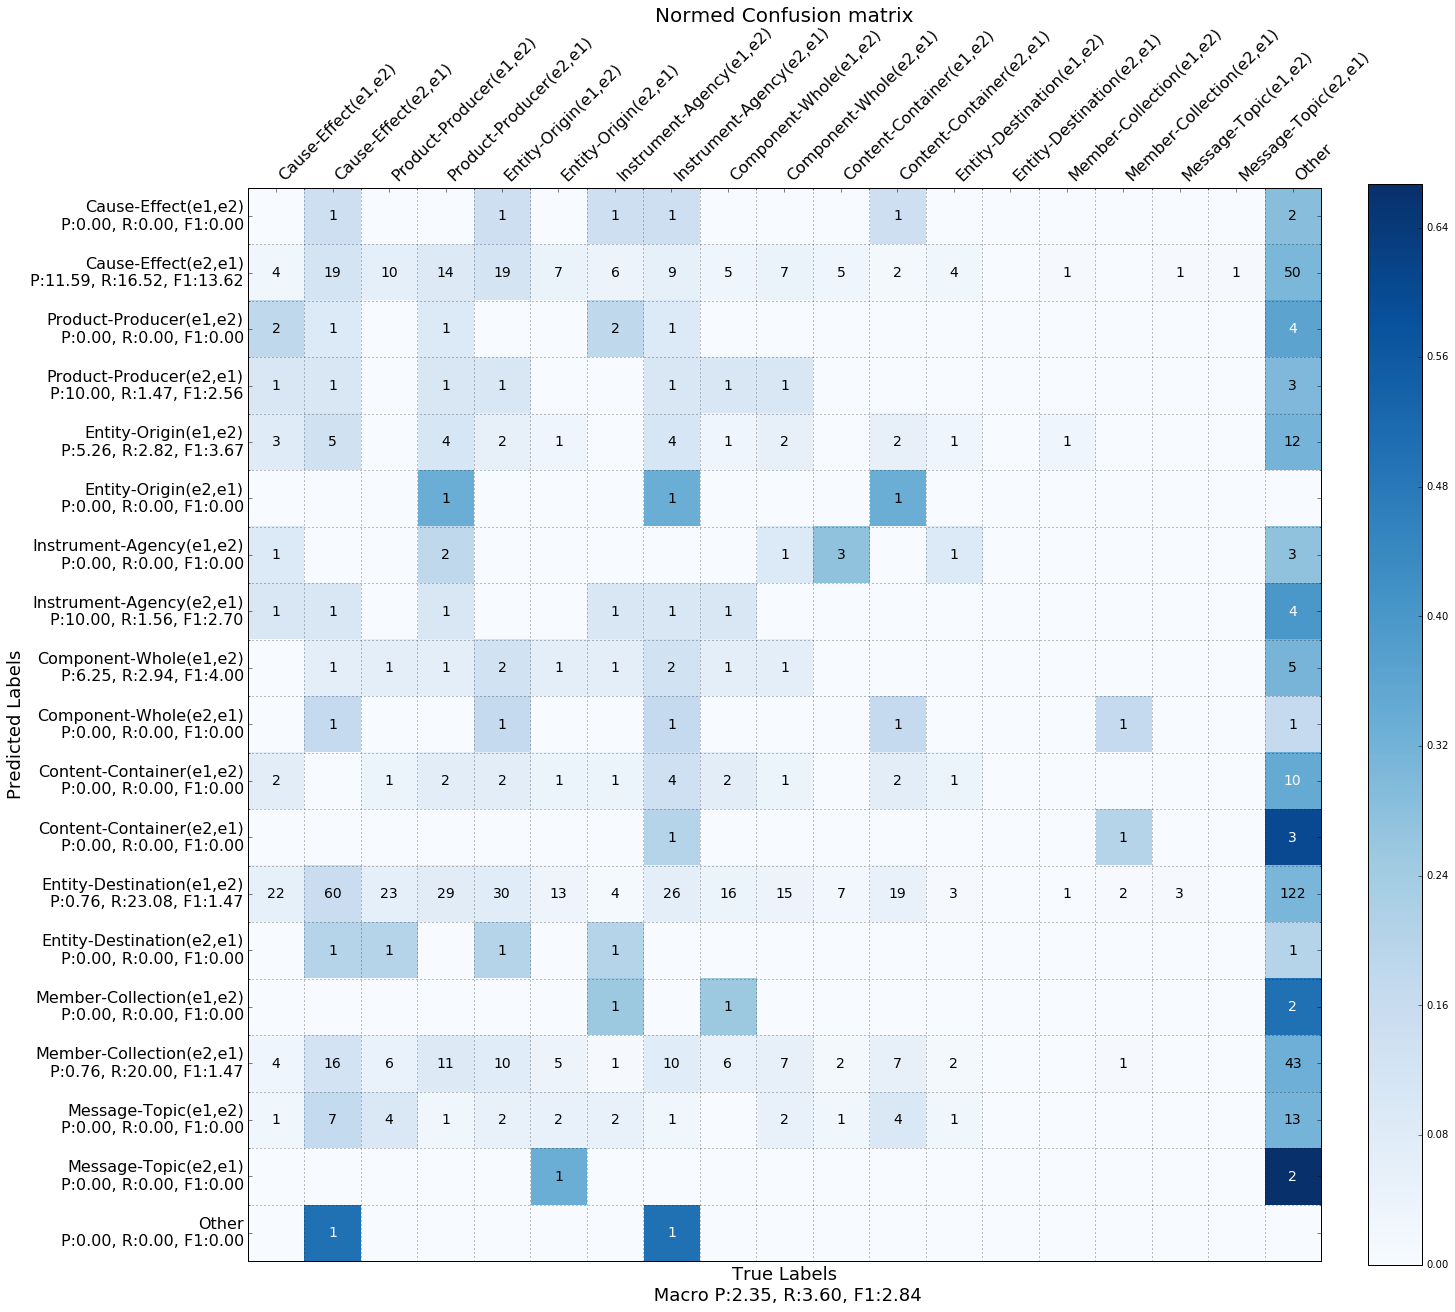

In [126]:
def plot_confusion_matrix(cm, label_names, save_name=None, title='Normed Confusion matrix', cmap=plt.cm.Blues, stats=None):
    fig, ax = plt.subplots(figsize=(20,20))
    
    # calc normalized cm
    x, y = np.meshgrid(range(cm.shape[0]), range(cm.shape[1]))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_normalized[np.isnan(cm_normalized)] = 0.0
    cm_max = np.max(cm_normalized)
    cm_min = np.min(cm_normalized)
    half_way = (cm_max - cm_min)/2.
    # print nonzero raw counts
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        norm = cm_normalized[x_val, y_val]
        c = "%i" % (cm.astype('int')[x_val, y_val])
        if norm > 0.0:
            color = 'white' if norm > half_way else 'black'
            ax.text(y_val, x_val, c, va='center', ha='center', color=color, fontsize=14)
    
    # actual plot
    im = ax.imshow(cm_normalized, interpolation='nearest', origin='upper', cmap=cmap)
#     divider = plt.make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    
    # set ticks and offset grid
    tick_marks = np.arange(len(label_names))
    tick_marks_offset = np.arange(len(label_names)) - .5
    ax.set_xticks(tick_marks, minor=False)
    ax.set_yticks(tick_marks, minor=False)
    ax.set_xticks(tick_marks_offset, minor=True)
    ax.set_yticks(tick_marks_offset, minor=True)
    ax.grid(which='minor')
    if stats:
        # include micro precisio, recall, and f1
        aug_y_labels = []
        for i in range(len(label_names)):
            aug = ("%s\nP:%2.2f, R:%2.2f, F1:%2.2f" 
                   % (label_names[i],
                      stats['micro_precision'][i],
                      stats['micro_recall'][i],
                      stats['micro_f1'][i],))
            aug_y_labels.append(aug)
    else:
        aug_x_labels = label_names
    ax.set_xticklabels(label_names, rotation=45, horizontalalignment='left', x=1, fontsize=16)
    ax.xaxis.tick_top()
    ax.set_yticklabels(aug_y_labels, fontsize=16)
    
    # other stuff
    plt.tight_layout()
    plt.ylabel('Predicted Labels', fontsize=18)
    if stats:
        # include macro 
        aug_x_label = ("True Labels\n Macro P:%2.2f, R:%2.2f, F1:%2.2f" 
                       % (stats['macro_precision'], stats['macro_recall'], stats['macro_f1']))
    else:
        aug_x_label = "True Label"
    plt.xlabel(aug_x_label, fontsize=18)
    plt.title(title, y=1.15, fontsize=20)
    if save_name:
        plt.savefig('figures/'+save_name+'.pdf')
        

save_name = raw_input("Enter save name: (last was '%s') " % save_name)
plot_confusion_matrix(cm, int2label.values(), save_name=save_name, stats=stats)

In [119]:
# write out predictions for test set
test_batch = DH.classification_batch(len(test['targets']), test['sdps'], test['targets'], 
                                     np.zeros(len(test['targets'])), shuffle=False)
preds = drnn.predict(test_batch[0], test_batch[1], test_batch[3])
# print(preds)

In [120]:
with open('SemEval2010_task8_all_data/test_pred.txt', 'w') as f:
    i = 8001
    for pred in preds:
        f.write("%i\t%s\n" % (i, int2label[pred]))
        i += 1

In [ ]:
# # reformat test keys because apparently that's broken...
# test_keys =  open("SemEval2010_task8_all_data/SemEval2010_task8_testing_keys/TEST_FILE_FULL.TXT", 'r').readlines()
# with open("SemEval2010_task8_all_data/test_keys.txt", 'w') as out:
#     for i in range(len(test_keys) //4):
#         nu
m = test_keys[4*i].split()[0]
#         label = test_keys[4*i+1]
#         out.write("%s\t%s" % (num, label))

In [10]:
e

In [6]:
# write out the training and validation as well
with open('SemEval2010_task8_all_data/train_preds.txt', 'w') as f:
    i = 1
    for label in preds:
        f.write("%s\t%s\n" % (i, int2label[label]))
        i += 1
with open('SemEval2010_task8_all_data/valid_preds.txt', 'w') as f:
    i = 8000 - 891 + 1
    for label in train['labels']:
        f.write("%s\t%s\n" % (i, int2label[label]))
        i += 1

In [9]:
%%bash
./SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl \
SemEval2010_task8_all_data/train_preds.txt SemEval2010_task8_all_data/train_keys.txt;

<<< (2*9+1)-WAY EVALUATION (USING DIRECTIONALITY)>>>:

Confusion matrix:
        C-E1 C-E2 C-W1 C-W2 C-C1 C-C2 E-D1 E-D2 E-O1 E-O2 I-A1 I-A2 M-C1 M-C2 M-T1 M-T2 P-P1 P-P2  _O_ <-- classified as
      +-----------------------------------------------------------------------------------------------+ -SUM- skip ACTUAL
 C-E1 | 303    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 |  303    0  303
 C-E2 |   0  544    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 |  544    0  544
 C-W1 |   0    0  436    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 |  436    0  436
 C-W2 |   0    0    0  434    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 |  434    0  434
 C-C1 |   0    0    0    0  356    0    0    0    0    0    0    0    0    0    0    0    0    0    0 |  356    0  356
 C-C2 |   0    0    0    0    0  127    0    0    0    0    0    0    0    0    0    0   

Use of uninitialized value in subtraction (-) at ./SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl line 288.
Use of uninitialized value in printf at ./SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl line 288.


In [121]:
%%bash
./SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/semeval2010_task8_format_checker.pl \
SemEval2010_task8_all_data/test_pred.txt;
./SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/semeval2010_task8_format_checker.pl \
SemEval2010_task8_all_data/test_keys.txt;
./SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl \
SemEval2010_task8_all_data/test_pred.txt SemEval2010_task8_all_data/test_keys.txt;


<<< The file format is OK.

<<< The file format is OK.
<<< (2*9+1)-WAY EVALUATION (USING DIRECTIONALITY)>>>:

Confusion matrix:
        C-E1 C-E2 C-W1 C-W2 C-C1 C-C2 E-D1 E-D2 E-O1 E-O2 I-A1 I-A2 M-C1 M-C2 M-T1 M-T2 P-P1 P-P2  _O_ <-- classified as
      +-----------------------------------------------------------------------------------------------+ -SUM- skip ACTUAL
 C-E1 |   3    5    2    1   12    0   39    0   12    0    0    8    0   16   16    3    2   13    2 |  134    0  134
 C-E2 |  10    7    6    3   21    0   54    0   10    1    0    9    0   12   29    1    9   21    1 |  194    0  194
 C-W1 |   3    8    5    4   16    0   53    0    9    1    3   15    0   14   16    0    0   15    0 |  162    0  162
 C-W2 |   5   12    3    3   16    0   46    0   10    0    3   12    0    8   19    0    2   10    1 |  150    0  150
 C-C1 |   2    7    8    2   23    0   43    0    6    0    1   10    0   15   22    1    1   12    0 |  153    0  153
 C-C2 |   2    1    1    1    4  

In [ ]:
train, valid, test, label2int, int2label = sdh.load_semeval_data()

In [ ]:
sentences = [ sent[0] for sent in train['sents']+valid['sents']+test['sents'] ]

In [ ]:
print(sentences[:5])

In [ ]:
def a():
    data = (1,2,3)
    return data 

In [ ]:
print(a())

In [ ]:
i, t, l = valid['sdps'][:3], valid['targets'][:3], valid['labels'][:3]
d = zip(i,t,l)
for a,b,c in d:
    print(a,b,c)
random.shuffle(d)
for a,b,c in d:
    print(a,b,c)
j,r,m = zip(*d)

In [124]:


for cycle in range(20):
    print("+"*80)
    print("CYCLE %i" % cycle)
    print("+"*80)
    # hyperparameters
    num_epochs = 1
    batch_size =50
    neg_per = 25
    num_nearby = 20
    nearby_mod = 50
    sample_power = .75
    DH.scale_vocab_dist(sample_power)

    # # bookkeeping
    num_steps = DH.num_steps(batch_size)
    total_step = 1
    save_interval = 30 * 60 # half hour in seconds
    save_time = time()

    #timing stuff
    start = time()
    fit_time = 0
    nearby_time = 0
    print("===== UNSUPERVISED TRAINING =====")
    for epoch in range(num_epochs):
        if cycle == 0: break # do supervised first
        offset = 0 #if epoch else 400
        DH.shuffle_data()
        for step , batch in enumerate(DH.batches(batch_size, offset=offset, neg_per=neg_per)):
            if not step: step = offset
            t0 = time()
            loss = drnn.partial_unsup_fit(*batch)
            fit_time = (fit_time * float(total_step) +  time() - t0) / (total_step + 1) # running average
            if step % 10 == 0:
                m,s = divmod(time()-start, 60)
                h,m = divmod(m, 60)
                left = time_left(num_epochs, num_steps, fit_time, nearby_time, start, nearby_mod)
                ml,sl = divmod(left, 60)
                hl,ml = divmod(ml, 60)
                pps = batch_size*(neg_per + 1) / fit_time 
                print("(%i:%i:%i) step %i/%i, epoch %i Training Loss = %1.5f :: %0.3f phrases/sec :: (%i:%i:%i) hours left" 
                      % (h,m,s, step, num_steps, epoch, loss, pps, hl, ml, sl))
            if (total_step-1) % nearby_mod == 0: # do one right away so we get a good timing estimate
                t0 = time()
                run_validation_test(num_nearby) # check out the nearby phrases in the validation set
                valid_loss = drnn.validation_loss(*DH.validation_batch())
                print("Validation loss: %0.4f" % valid_loss)
                nearby_time = (nearby_time * float(total_step) + time() - t0) / (total_step + 1) # running average

            if (time() - save_time) > save_interval:
                print("Saving model...")
                drnn.checkpoint()
                save_time = time()
            total_step +=1
        valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
        label_set = set(train['labels'])
        preds = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[3])
        cm, stats = confusion_matrix(preds, valid['labels'], label_set)
        print("Macro P: %2.4f, R: %3.4f, F1: %0.4f" % (stats['macro_precision'], stats['macro_recall'], stats['macro_f1']))
    drnn.checkpoint()

    batch_size = 50
    class_steps = len(train['labels']) // batch_size
    class_epochs = 5
    display_mod = 10
    valid_mod = 50



    print(num_steps)
    print("***** SUPERVISED TRAINING *****")
    start = time()
    for class_epoch in range(class_epochs):
    #     class_batch = DH.classification_batch(batch_size, train['sdps'], train['targets'], train['labels'], offset=0)
    #     random.shuffle(class_batch)

        for class_step in range(class_steps):
            inputs, targets, labels, lens = DH.classification_batch(batch_size, train['sdps'], train['targets'], train['labels'], offset=class_step)
            class_batch = zip(inputs, targets, labels, lens)
            random.shuffle(class_batch)
            class_batch = zip(*class_batch)
            xent = drnn.partial_class_fit(*class_batch)
            if class_step % display_mod == 0:   
                m,s = divmod(time()-start, 60)
                h,m = divmod(m, 60)
                print("(%i:%i:%i) s %i/%i, e %i avg class xent loss = %0.4f" % (h,m,s, class_step, num_steps, class_epoch, xent))
            if class_step % valid_mod == 0:
                valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
                valid_xent = drnn.validation_class_loss(*valid_batch)
                m,s = divmod(time()-start, 60)
                h,m = divmod(m, 60)
                print("="*80)
                print("(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f" % (h,m,s, class_step, num_steps, class_epoch, valid_xent))
                print("="*80)
    #             print("Saving model...")
    #             drnn.checkpoint()
        label_set = set(train['labels'])
        preds = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[3])
        cm, stats = confusion_matrix(preds, valid['labels'], label_set)
        print("Macro P: %2.4f, R: %3.4f, F1: %0.4f" % (stats['macro_precision'], stats['macro_recall'], stats['macro_f1']))
    drnn.checkpoint()
print("Done")

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
CYCLE 0
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
===== UNSUPERVISED TRAINING =====
Saving model to file: checkpoints/semeval_blank_rank_lambda_0.01_clip1.ckpt-2860-11522
143
***** SUPERVISED TRAINING *****
(0:0:0) s 0/143, e 0 avg class xent loss = 38.7017
(0:0:7) s 0/143, e 0 validation avg class xent loss = 42.5642
(0:0:15) s 10/143, e 0 avg class xent loss = 38.1246
(0:0:23) s 20/143, e 0 avg class xent loss = 44.9585
(0:0:30) s 30/143, e 0 avg class xent loss = 38.1478
(0:0:38) s 40/143, e 0 avg class xent loss = 45.2779
(0:0:45) s 50/143, e 0 avg class xent loss = 39.5168
(0:0:53) s 50/143, e 0 validation avg class xent loss = 41.6482
(0:1:0) s 60/143, e 0 avg class xent loss = 42.9935
(0:1:8) s 70/143, e 0 avg class xent loss = 39.4292
(0:1:16) s 80/143, e 0 avg class xent loss = 37.6740
(0:1:23) s 90/143, e 0 avg class xent loss = 43.5841
(0:1:31) s 100/143, e

KeyboardInterrupt: 